In [1]:
import importlib
import gpudrive
importlib.reload(gpudrive)

import numpy as np
import os
import torch
from pathlib import Path

# Set working directory to the base directory 'gpudrive_madrona'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive_madrona' not found")
os.chdir(working_dir)
import torch
from PIL import Image
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.config import EnvConfig, RenderConfig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.visualize.utils import img_from_fig

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (10, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")
mpl.rcParams["lines.markersize"] = 8

plt.set_loglevel("WARNING")
%matplotlib inline

In [2]:
MS = 9
 
def plot_agent_guidance_info(guidance_obs, center_agent_idx):
 
    agent_guidance = guidance_obs[center_agent_idx, :, :]
    mask = agent_guidance[:, 0] != -1.0
    
    time_steps = np.arange(agent_guidance.shape[0])
    
    fig, axes = plt.subplots(1, 3, figsize=(9.5, 3))
  
    axes[0].scatter(agent_guidance[:, 0][mask], agent_guidance[:, 1][mask], marker='o', s=MS, color='g')  
    axes[0].set_xlabel(r'Suggested $x$')
    axes[0].set_ylabel(r'Suggested $y$')
    #axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(time_steps[mask], agent_guidance[:, 2][mask], marker='o', color='b', s=MS)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Suggested speed')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].scatter(time_steps[mask], agent_guidance[:, 3][mask], marker='o', color='#bc6c25', s=MS)
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Suggested heading (rad)')
    axes[2].grid(True, alpha=0.3)
    
    #fig.suptitle(f"Agent's {center_agent_idx} normalized guidance information")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15)
    
    return fig

In [3]:
DATASET = "data/processed/wosac/validation_json_100"
FIGURES_DIR = "examples/eval/figures"
DATA_FOLDER = "examples/eval/figures_data/"

### Checking guidance data

In [4]:
# Load npy array from the file
FOLDER = "examples/eval/figures_data/guidance/"

ref_log_replay = np.load(f"{FOLDER}reference_log_replay.npy")
ref_vbd_amortized = np.load(f"{FOLDER}reference_vbd_amortized.npy")
ref_vbd_online = np.load(f"{FOLDER}reference_vbd_online.npy")

In [5]:
# Should all be 91 

# Controlled agent elements for 10 scenarios
ref_log_replay.shape, ref_vbd_amortized.shape, ref_vbd_online.shape

((204, 91, 6), (204, 91, 6), (210, 91, 6))

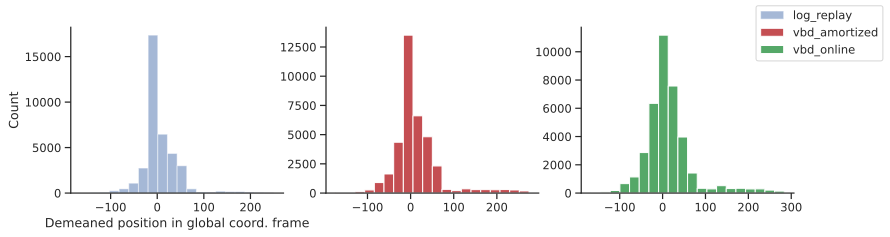

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3),)# sharex=True, sharey=True)

axs[0].hist(ref_log_replay[:, :, :2].flatten(), color='b', alpha=0.5, bins=20, label="log_replay")
axs[1].hist(ref_vbd_amortized[:, :, :2].flatten(), color='r', alpha=1.0, bins=20, label="vbd_amortized")
axs[2].hist(ref_vbd_online[:, :, :2].flatten(), color='g', alpha=1.0, bins=20, label="vbd_online")

axs[0].set_xlabel("Demeaned position in global coord. frame")
axs[0].set_ylabel("Count")

fig.legend()
sns.despine()

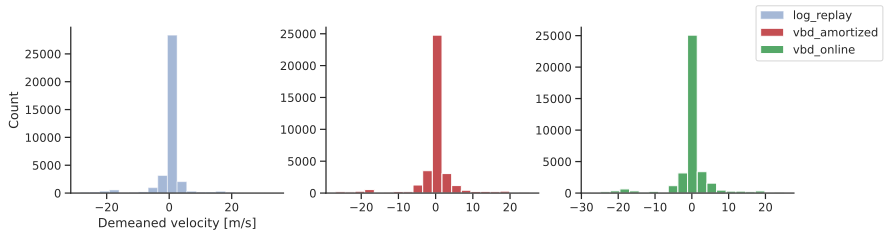

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3) )# sharex=True, sharey=True)

axs[0].hist(ref_log_replay[:, :, 2:4].flatten(), color='b', alpha=0.5, bins=20, label="log_replay")
axs[1].hist(ref_vbd_amortized[:, :, 2:4].flatten(), color='r', alpha=1.0, bins=20, label="vbd_amortized")
axs[2].hist(ref_vbd_online[:, :, 2:4].flatten(), color='g', alpha=1.0, bins=20, label="vbd_online")

axs[0].set_xlabel("Demeaned velocity [m/s]")
axs[0].set_ylabel("Count")

fig.legend()
sns.despine()

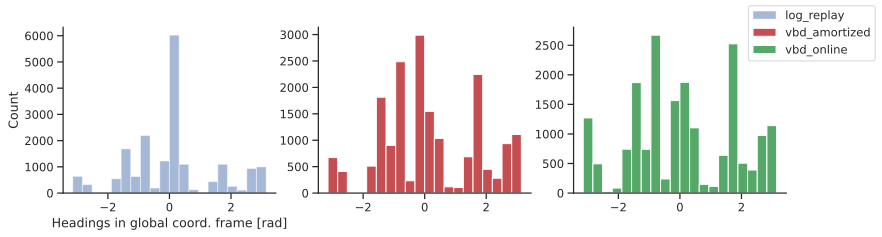

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3),)# sharex=True, sharey=True)

axs[0].hist(ref_log_replay[:, :, 4].flatten(), color='b', alpha=0.5, bins=20, label="log_replay")
axs[1].hist(ref_vbd_amortized[:, :, 4].flatten(), color='r', alpha=1.0, bins=20, label="vbd_amortized")
axs[2].hist(ref_vbd_online[:, :, 4].flatten(), color='g', alpha=1.0, bins=20, label="vbd_online")

axs[0].set_xlabel("Headings in global coord. frame [rad]")
axs[0].set_ylabel("Count")

# add legend
fig.legend()
sns.despine()

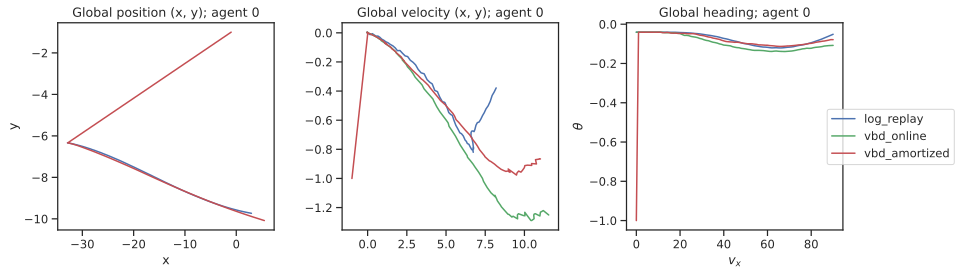

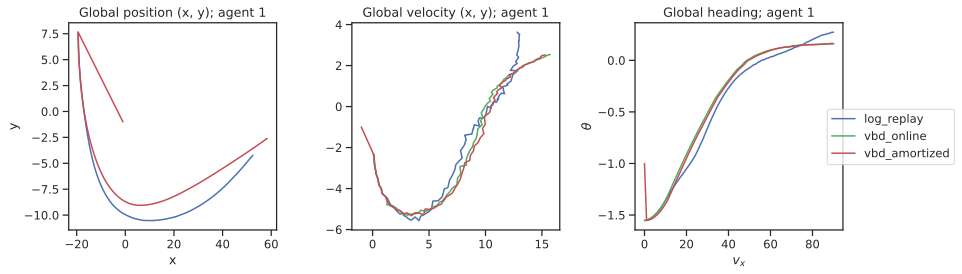

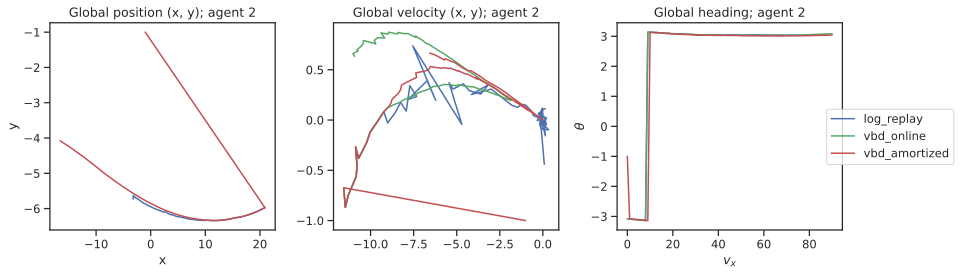

In [30]:
for agent_idx in range(3):
    
    valid = ref_log_replay[agent_idx, :, -1].astype( bool)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].set_title(f"Global position (x, y); agent {agent_idx}")
    axs[0].plot(ref_log_replay[agent_idx, :, 0][valid], ref_log_replay[agent_idx, :, 1][valid], color='b')
    #axs[0].plot(ref_vbd_online[agent_idx, :, 0], ref_vbd_online[agent_idx, :, 1], color='g', alpha=0.5)
    axs[0].plot(ref_vbd_amortized[agent_idx, :, 0], ref_vbd_amortized[agent_idx, :, 1], color='r')
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    axs[1].set_title(f"Global velocity (x, y); agent {agent_idx}")
    axs[1].plot(ref_log_replay[agent_idx, :, 2][valid], ref_log_replay[agent_idx, :, 3][valid], color='b')
    axs[1].plot(ref_vbd_online[agent_idx, :, 2], ref_vbd_online[agent_idx, :, 3], color='g')
    axs[1].plot(ref_vbd_amortized[agent_idx, :, 2], ref_vbd_amortized[agent_idx, :, 3], color='r')
    axs[2].set_xlabel(r"$v_x$")
    axs[2].set_ylabel(r"$v_y$")

    axs[2].set_title(f"Global heading; agent {agent_idx}")
    axs[2].plot(ref_log_replay[agent_idx, :, 4][valid], color='b', label="log_replay")
    axs[2].plot(ref_vbd_online[agent_idx, :, 4], color='g', label="vbd_online")
    axs[2].plot(ref_vbd_amortized[agent_idx, :, 4], color='r', label="vbd_amortized")
    axs[2].set_ylabel(r"$\theta$")

    plt.tight_layout()

    fig.legend(loc="center right", facecolor="white", bbox_to_anchor=(1.12, 0.5))
    plt.show()

### Dataset stats

In [31]:
valid_guidance_points = ref_log_replay[:, :, 5].sum(axis=-1)
valid_guidance_points.shape

# Some trajectories, while valid, are just parked cars
# Detect these by checking for zero velocity trajectories
valid_and_non_zero = ((ref_log_replay[:, :, 2] != 0) & (ref_log_replay[:, :, 5] == 1)).sum(axis=1)

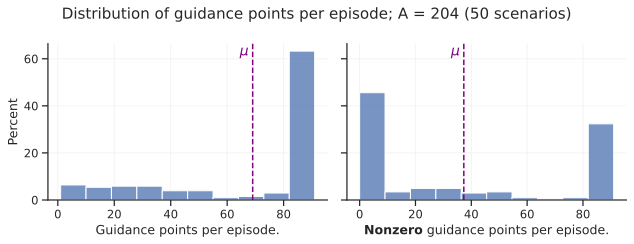

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True)

fig.suptitle(f"Distribution of guidance points per episode; A = {ref_log_replay.shape[0]} (50 scenarios)")

sns.histplot(valid_guidance_points, bins=10, stat='percent', ax=axs[0])
axs[0].grid(True, alpha=0.2)
axs[0].set_xlabel("Guidance points per episode.")
mean_value = valid_guidance_points.mean()
axs[0].axvline(x=mean_value, color='purple', linestyle='--')
axs[0].text(mean_value-3, axs[0].get_ylim()[1]*0.95, r'$\mu$', color='purple', 
            fontsize=14, ha='center', va='center')

sns.histplot(valid_and_non_zero, bins=10, stat='percent', ax=axs[1])
axs[1].grid(True, alpha=0.2)
axs[1].set_xlabel(r"$\bf{Nonzero}$ guidance points per episode.")
mean_value_nonzero = valid_and_non_zero.mean()
axs[1].axvline(x=mean_value_nonzero, color='purple', linestyle='--')
axs[1].text(mean_value_nonzero-3, axs[1].get_ylim()[1]*0.95, r'$\mu$', color='purple', fontsize=14, ha='center', va='center')

plt.tight_layout()
sns.despine()
plt.savefig(f"{FIGURES_DIR}/guidance_points_distribution.pdf", dpi=300, bbox_inches="tight")

### Make guidance figs

In [13]:
GUIDANCE_MODE = "log_replay"
GUIDANCE_DROPOUT = 0.99
GUIDANCE_DROPOUT_MODE = "avg"

env_config = EnvConfig(
    reward_type="guided_autonomy",
    guidance=True,
    guidance_mode=GUIDANCE_MODE,
    add_reference_heading=True,
    add_reference_speed=True,
    add_reference_pos_xy=True,
    init_mode="wosac_train",
    smoothen_trajectory=False,
    dynamics_model="delta_local",
    guidance_dropout_prob=GUIDANCE_DROPOUT,
    guidance_dropout_mode=GUIDANCE_DROPOUT_MODE,
    init_steps=0,
)
render_config = RenderConfig()

train_loader = SceneDataLoader(
    root=DATASET,
    batch_size=1,
    dataset_size=100,
    sample_with_replacement=False,
    shuffle=True,
    file_prefix="",
    
)

env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=32, 
    device="cpu",
)

print(env.data_batch)

obs = env.reset(env.cont_agent_mask)
expert_actions, _, _, _ = env.get_expert_actions()

# for time_step in range(env.init_steps, 20):
#     print(f"Step: {env.step_in_world[0, 0, 0].item()}")

#     # Step the environment
#     expert_actions, _, _, _ = env.get_expert_actions()
#     env.step_dynamics(expert_actions[:, :, time_step, :])

#     obs = env.get_obs(env.cont_agent_mask)
#     rew = env.get_rewards()
    

# # Save for analysis
# reference_traj = torch.cat([
#     env.reference_trajectory.pos_xy,
#     env.reference_trajectory.vel_xy,
#     env.reference_trajectory.yaw,
#     env.reference_trajectory.valids,
# ], dim=-1)
# reference_traj_np = reference_traj[env.cont_agent_mask].numpy()

# np.save(f"reference_{GUIDANCE_MODE}.npy", reference_traj_np)

['data/processed/wosac/validation_json_100/5d710aa0c524f747.json']


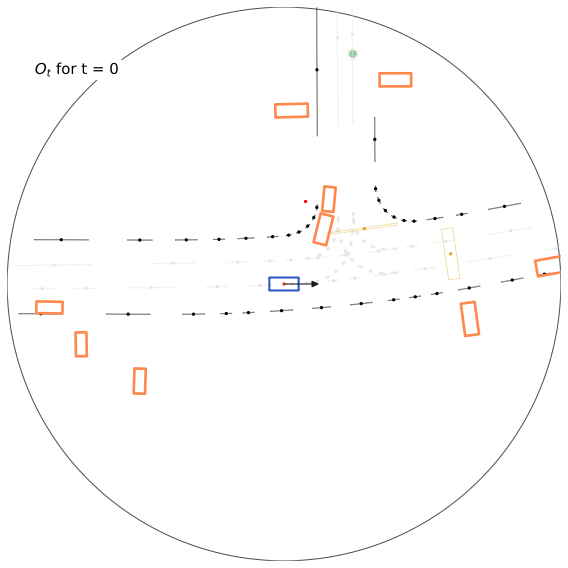

In [14]:
CENTER_AGENT_IDX = 0

fig = env.vis.plot_agent_observation(
    env_idx=0,
    agent_idx=CENTER_AGENT_IDX,
    figsize=(10, 10),
    trajectory=env.reference_path[CENTER_AGENT_IDX, :, :],
    # step_reward=env.guidance_reward[
    #     0, 1
    # ].item(),
    # route_progress=env.route_progress[1],
)

plt.savefig(
    os.path.join(FIGURES_DIR, f"agent_observation_{CENTER_AGENT_IDX}_{GUIDANCE_MODE}_dropout_{GUIDANCE_DROPOUT}_{GUIDANCE_DROPOUT_MODE}.pdf"),
    dpi=300,
    bbox_inches="tight",
)

In [1]:
fig = plot_agent_guidance_info(env.guidance_obs, center_agent_idx=1);

plt.savefig(
    os.path.join(FIGURES_DIR, f"agent_guidance_info_{CENTER_AGENT_IDX}_{GUIDANCE_MODE}.pdf"),
    dpi=300,
    bbox_inches="tight",
)

NameError: name 'plot_agent_guidance_info' is not defined